In [65]:
import os
import torch
import torchvision
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Load the data

In [2]:
!git clone https://github.com/ayulockin/faceattributes.git

Cloning into 'faceattributes'...
remote: Enumerating objects: 23407, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 23407 (delta 4), reused 6 (delta 1), pack-reused 23388
Receiving objects: 100% (23407/23407), 115.73 MiB | 20.81 MiB/s, done.
Resolving deltas: 100% (16/16), done.
Checking out files: 100% (23747/23747), done.


In [5]:
os.chdir('faceattributes/')

In [6]:
import pandas as pd

df = pd.read_csv('/content/faceattributes/datasets/face_dataset.csv')

In [7]:
df.head()

,image_id,age,gender,ethnicity
0,teripprmot,100,0,0
1,ibjkghymsu,100,0,0
2,dlsaxmcymo,100,1,0
3,oyyopnhvza,100,1,0
4,nhufelmwaw,100,1,0


In [8]:
len(os.listdir('/content/faceattributes/images'))

23705

## Display image

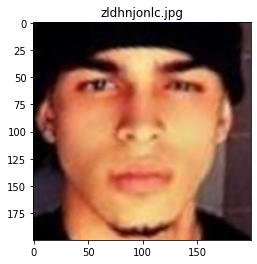

In [13]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

test_image = os.listdir('/content/faceattributes/images')[0]
 
plt.title(test_image)
# plt.xlabel("X pixel scaling")
# plt.ylabel("Y pixels scaling")
 
image = mpimg.imread('/content/faceattributes/images/' + test_image)
plt.imshow(image)
plt.show()

## Load CLIP

In [15]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 4.8 MB/s 
     |████████████████████████████████| 7.6 MB 41.3 MB/s 
     |████████████████████████████████| 163 kB 61.8 MB/s 


In [47]:
from PIL import Image
import requests
from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

model.to('cuda')
# processor.to('cuda') --> can't do this

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

inputs = processor(text=["a photo of a cat", "a photo of a dog"], images=image, return_tensors="pt", padding=True)
inputs.to('cuda')
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities

In [48]:
probs

tensor([[0.9949, 0.0051]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

## Race classification

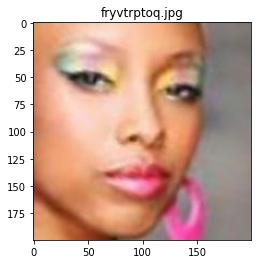

In [18]:
test_image = os.listdir('/content/faceattributes/images')[1]
 
plt.title(test_image)
# plt.xlabel("X pixel scaling")
# plt.ylabel("Y pixels scaling")
 
image = mpimg.imread('/content/faceattributes/images/' + test_image)
plt.imshow(image)
plt.show()

In [23]:
test_image = Image.open('/content/faceattributes/images/' + os.listdir('/content/faceattributes/images')[1])
inputs = processor(text=["a fair-skinned person", "a dark-skinned person"], images=test_image, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities

probs

tensor([[0.2193, 0.7807]], grad_fn=<SoftmaxBackward0>)

Let's sample equal number of images

```
[race] is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).
```

Let
- light-skinned 0 = white 0, asian 2
- dark-skinned 1 = black 1, indian 3
- ignore other

In [37]:
white_samples = df[df['ethnicity'] == 0].sample(1000)
black_samples = df[df['ethnicity'] == 1].sample(1000)
asian_samples = df[df['ethnicity'] == 2].sample(1000)
indian_samples = df[df['ethnicity'] == 3].sample(1000)

sampled = pd.concat((white_samples, black_samples, asian_samples, indian_samples))

In [39]:
from sklearn.utils import shuffle
sampled = shuffle(sampled)

In [40]:
sampled

,image_id,age,gender,ethnicity
10091,unhctwydph,2,0,2
16097,giclecinxw,42,0,1
3411,qxzsuszdcy,22,0,2
1819,zkjlksfiyf,1,0,2
11523,qchtbfzkee,31,1,2
...,...,...,...,...
747,taesymkenm,15,1,1
12254,gxptxekdej,33,0,0
10191,hlurusegaz,2,0,2
20152,smnrmqwbly,59,1,3


In [41]:
sampled.image_id.values

array(['unhctwydph', 'giclecinxw', 'qxzsuszdcy', ..., 'hlurusegaz',
       'smnrmqwbly', 'onrlwdxfdx'], dtype=object)

In [51]:
IMAGES_FOLDER = '/content/faceattributes/images/'
all_images = [img + '.jpg' for img in sampled.image_id.values]

preds = {}

for filename in tqdm(all_images): 
    image = IMAGES_FOLDER + filename
    test_image = Image.open(image)
    inputs = processor(text=["a fair-skinned person", "a dark-skinned person"], images=test_image, return_tensors="pt", padding=True)
    inputs.to('cuda')

    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image # this is the image-text similarity score
    probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities

    label = torch.argmax(probs)
    preds[filename] = label.item()

  0%|          | 0/4000 [00:00<?, ?it/s]

In [52]:
preds

{'unhctwydph.jpg': 1,
 'giclecinxw.jpg': 1,
 'qxzsuszdcy.jpg': 0,
 'zkjlksfiyf.jpg': 0,
 'qchtbfzkee.jpg': 0,
 'hnzoxtoeaa.jpg': 0,
 'usuauhnlyo.jpg': 1,
 'zblpnlxpsh.jpg': 0,
 'otxwpczuif.jpg': 1,
 'wjugszysez.jpg': 1,
 'jpgsafbkkz.jpg': 1,
 'wwunhbojta.jpg': 0,
 'cxgywjmbny.jpg': 0,
 'lksstvjuuo.jpg': 0,
 'smpsldvlzs.jpg': 1,
 'rkkithsuth.jpg': 0,
 'hvnnvcdbuf.jpg': 1,
 'tnturkhzqz.jpg': 0,
 'gkeaxcuumo.jpg': 0,
 'cdtpyselge.jpg': 0,
 'hccrjrgxec.jpg': 0,
 'eyiywekmew.jpg': 1,
 'yyuludeclj.jpg': 0,
 'jfjchnxsrt.jpg': 1,
 'wdbjmhqysy.jpg': 0,
 'izyaleggbm.jpg': 1,
 'ncmnelbqok.jpg': 1,
 'ghvbqxjsup.jpg': 0,
 'rxavwtfdwg.jpg': 1,
 'igddiijyex.jpg': 0,
 'iljlnxmood.jpg': 0,
 'luziofjavl.jpg': 0,
 'ddvktrqnjk.jpg': 1,
 'iectvkewci.jpg': 1,
 'tytxjbvdyc.jpg': 0,
 'gllujbolbg.jpg': 0,
 'pwieybnmcg.jpg': 1,
 'gdxgafdrxz.jpg': 1,
 'szqgqeszsp.jpg': 1,
 'pvfpsugxim.jpg': 0,
 'ezforwtzom.jpg': 0,
 'pifcihuozp.jpg': 1,
 'ukounitxyy.jpg': 1,
 'fzlnndehwl.jpg': 1,
 'egbvynhstu.jpg': 0,
 'morfnrsk

In [55]:
skin_true = []

for eth in tqdm(sampled['ethnicity']):
    if eth == 0 or eth == 2:
        skin_true.append(0) # fair skinned
    else:
        skin_true.append(1)


skin_pred = []

for img in tqdm(sampled['image_id']):
    img = img + '.jpg'
    pred = preds[img]
    skin_pred.append(pred)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [57]:
sampled['skin_true'] = skin_true
sampled['skin_pred'] = skin_pred

In [58]:
correct = 0

for i, skin in enumerate(skin_true):
    if skin == skin_pred[i]:
        correct += 1

print("Accuracy: {}".format(correct/len(skin_true)))

Accuracy: 0.835


In [104]:
right_skin = sampled[sampled['skin_true'] == sampled['skin_pred']]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


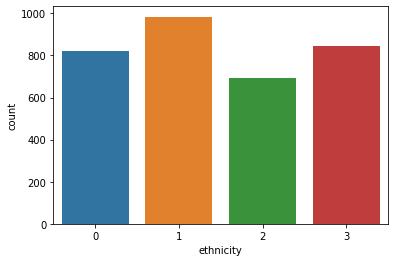

In [106]:
sns.countplot(right_skin['ethnicity'])

### Error analysis

In [63]:
wrong_skin = sampled[sampled['skin_true'] != sampled['skin_pred']]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


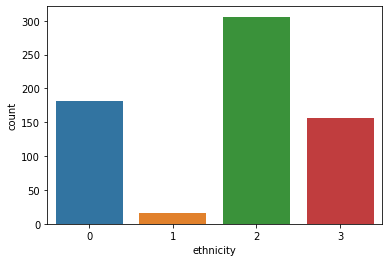

In [69]:
sns.countplot(wrong_skin['ethnicity'])

In [95]:
def img_reshape(img):
    img = Image.open('/content/faceattributes/images/'+img+'.jpg').convert('RGB')
    img = img.resize((300,300))
    img = np.asarray(img)
    return img


def display(images):
    rows = 1
    cols = 10
    img_count = 0

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15,15))

    for j in range(cols):
        axes[j].imshow(img_reshape(images[img_count]))
        axes[j].axis('off')
        img_count+=1

In [70]:
# fair mislabeled as dark
wrong_skin[wrong_skin['skin_true'] == 0]

,image_id,age,gender,ethnicity,skin_true,skin_pred
10091,unhctwydph,2,0,2,0,1
1770,iectvkewci,1,0,2,0,1
2305,gdxgafdrxz,1,1,0,0,1
15406,szqgqeszsp,40,0,0,0,1
2373,ingqiszfol,1,1,2,0,1
...,...,...,...,...,...,...
4008,khlfgiwhnj,23,1,2,0,1
11138,fzgyqtvizt,30,1,2,0,1
5808,xparhvrbtz,26,0,0,0,1
210,pmzjudyavs,11,0,2,0,1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


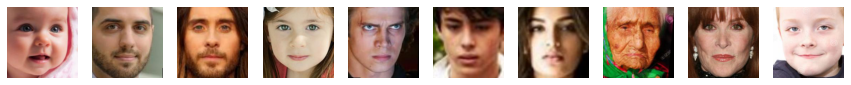

In [100]:
images = wrong_skin[wrong_skin['skin_true'] == 0][wrong_skin['ethnicity']==0].image_id.values
display(images)

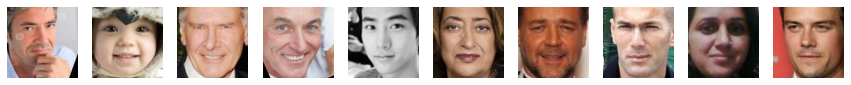

In [101]:
display(images[10:])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


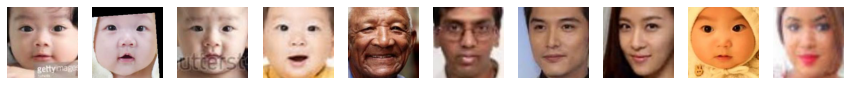

In [102]:
images = wrong_skin[wrong_skin['skin_true'] == 0][wrong_skin['ethnicity']==2].image_id.values
display(images)

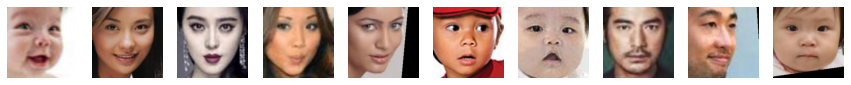

In [103]:
display(images[10:])

In [71]:
# dark mislabeled as fair
wrong_skin[wrong_skin['skin_true'] == 1]

,image_id,age,gender,ethnicity,skin_true,skin_pred
17571,hnzoxtoeaa,49,1,3,1,0
7605,yyuludeclj,26,1,3,1,0
15014,morfnrsknw,39,1,1,1,0
18360,qeyfunbyuh,51,1,1,1,0
22713,evrdfulamz,80,0,3,1,0
...,...,...,...,...,...,...
4907,ubdccopbdu,24,1,3,1,0
12780,gsljzoofcp,34,1,3,1,0
10008,ahmmsqzrjk,29,1,3,1,0
7770,gsiucygvul,26,1,3,1,0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


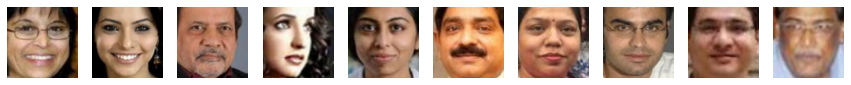

In [91]:
images = wrong_skin[wrong_skin['skin_true'] == 1][wrong_skin['ethnicity']==3].image_id.values
display(images)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


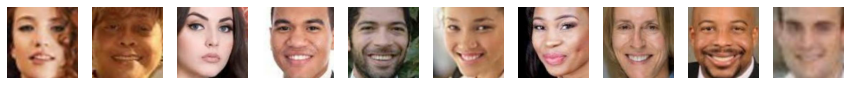

In [94]:
images = wrong_skin[wrong_skin['skin_true'] == 1][wrong_skin['ethnicity']==1].image_id.values
display(images)

## Gender Classification

Use another dataset

In [110]:
os.chdir('/content/')

In [111]:
!mkdir data_faces && wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip 

--2022-11-10 23:33:14--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.120.48
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.120.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443490838 (1.3G) [application/zip]
Saving to: ‘celeba.zip’

celeba.zip          100%[===================>]   1.34G  39.2MB/s    in 36s     

2022-11-10 23:33:49 (38.8 MB/s) - ‘celeba.zip’ saved [1443490838/1443490838]



In [112]:
!unzip celeba.zip

Streaming output truncated to the last 5000 lines.
 extracting: img_align_celeba/197600.jpg  
 extracting: img_align_celeba/197601.jpg  
 extracting: img_align_celeba/197602.jpg  
 extracting: img_align_celeba/197603.jpg  
 extracting: img_align_celeba/197604.jpg  
 extracting: img_align_celeba/197605.jpg  
 extracting: img_align_celeba/197606.jpg  
 extracting: img_align_celeba/197607.jpg  
 extracting: img_align_celeba/197608.jpg  
 extracting: img_align_celeba/197609.jpg  
 extracting: img_align_celeba/197610.jpg  
 extracting: img_align_celeba/197611.jpg  
 extracting: img_align_celeba/197612.jpg  
 extracting: img_align_celeba/197613.jpg  
 extracting: img_align_celeba/197614.jpg  
 extracting: img_align_celeba/197615.jpg  
 extracting: img_align_celeba/197616.jpg  
 extracting: img_align_celeba/197617.jpg  
 extracting: img_align_celeba/197618.jpg  
 extracting: img_align_celeba/197619.jpg  
 extracting: img_align_celeba/197620.jpg  
 extracting: img_align_celeba/197621.jpg  
 ex

In [114]:
len(os.listdir('/content/img_align_celeba'))

202599

In [116]:
def img_reshape(img):
    img = Image.open('/content/img_align_celeba/'+img).convert('RGB')
    img = img.resize((300,300))
    img = np.asarray(img)
    return img

def display(images):
    rows = 1
    cols = 10
    img_count = 0

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15,15))

    for j in range(cols):
        axes[j].imshow(img_reshape(images[img_count]))
        axes[j].axis('off')
        img_count+=1

In [117]:
os.listdir('/content/img_align_celeba')[0]

'045954.jpg'

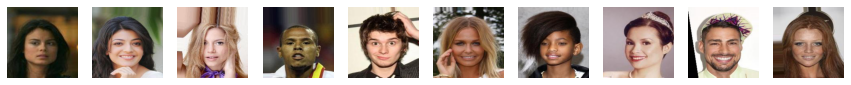

In [119]:
display(os.listdir('/content/img_align_celeba'))

### Load CLIP for gender

In [120]:
from PIL import Image
import requests
from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

model.to('cuda')
# processor.to('cuda') --> can't do this

image = Image.open('/content/img_align_celeba/045954.jpg')

inputs = processor(text=["a photo of a man", "a photo of a woman"], images=image, return_tensors="pt", padding=True)
inputs.to('cuda')
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities

In [121]:
probs

tensor([[0.0048, 0.9952]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

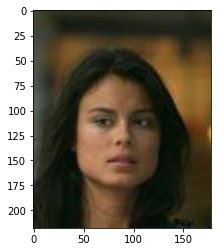

In [122]:
plt.imshow(image)

In [127]:
df = pd.read_csv('list_attr_celeba.txt', header='infer', delim_whitespace=True)

In [128]:
df

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202595.jpg,-1,-1,1,-1,-1,-1,1,-1,-1,1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1
202596.jpg,-1,-1,-1,-1,-1,1,1,-1,-1,1,...,-1,1,1,-1,-1,-1,-1,-1,-1,1
202597.jpg,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
202598.jpg,-1,1,1,-1,-1,-1,1,-1,1,-1,...,-1,1,-1,1,1,-1,1,-1,-1,1


In [130]:
gender_df = pd.DataFrame(df['Male'])

In [132]:
gender_df['Male'] = [0 if x == -1 else 1 for x in gender_df['Male'].values]

In [133]:
gender_df

,Male
000001.jpg,0
000002.jpg,0
000003.jpg,1
000004.jpg,0
000005.jpg,0
...,...
202595.jpg,0
202596.jpg,1
202597.jpg,1
202598.jpg,0


In [215]:
male = gender_df[gender_df['Male'] == 1].sample(2000)
female = gender_df[gender_df['Male'] == 0].sample(2000)

In [216]:
sampled = pd.concat((male, female))

In [217]:
from sklearn.utils import shuffle
sampled = shuffle(sampled)

In [218]:
sampled

,Male
129507.jpg,0
032535.jpg,1
052429.jpg,1
014262.jpg,0
110277.jpg,1
...,...
109035.jpg,1
062822.jpg,0
070510.jpg,1
012449.jpg,0


In [219]:
sampled.index.values

array(['129507.jpg', '032535.jpg', '052429.jpg', ..., '070510.jpg',
       '012449.jpg', '083876.jpg'], dtype=object)

In [220]:
IMAGES_FOLDER = '/content/img_align_celeba/'
all_images = sampled.index.values

male_probs = {}
female_probs = {}

for filename in tqdm(all_images): 
    image = IMAGES_FOLDER + filename
    test_image = Image.open(image)
    inputs = processor(text=["a photo of a woman", "a photo of a man"], images=test_image, return_tensors="pt", padding=True)
    inputs.to('cuda')

    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image # this is the image-text similarity score
    probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities
    
    female_probs[filename] = probs[0][0].item()
    male_probs[filename] = probs[0][1].item()

  0%|          | 0/4000 [00:00<?, ?it/s]

In [224]:
sampled

,gender
129507.jpg,0
032535.jpg,1
052429.jpg,1
014262.jpg,0
110277.jpg,1
...,...
109035.jpg,1
062822.jpg,0
070510.jpg,1
012449.jpg,0


In [222]:
sampled = sampled.rename(columns={"Male": "gender"})

In [223]:
sampled

,gender
129507.jpg,0
032535.jpg,1
052429.jpg,1
014262.jpg,0
110277.jpg,1
...,...
109035.jpg,1
062822.jpg,0
070510.jpg,1
012449.jpg,0


In [225]:
male_gender_prob = []
female_gender_prob = []

for img in sampled.index.values:
    male_gender_prob.append(male_probs[img])
    female_gender_prob.append(female_probs[img])

In [226]:
sampled['male_gender_prob'] = male_gender_prob
sampled['female_gender_prob'] = female_gender_prob

In [227]:
sampled

,gender,male_gender_prob,female_gender_prob
129507.jpg,0,0.002603,0.997397
032535.jpg,1,0.824646,0.175354
052429.jpg,1,0.990409,0.009591
014262.jpg,0,0.009436,0.990564
110277.jpg,1,0.929627,0.070373
...,...,...,...
109035.jpg,1,0.976254,0.023746
062822.jpg,0,0.022762,0.977238
070510.jpg,1,0.991748,0.008252
012449.jpg,0,0.004460,0.995540


In [187]:
correct = 0

for i, gen in enumerate(sampled['gender']):
    if gen == sampled['gender_pred'][i]:
        correct += 1

print("Accuracy: {}".format(correct/len(sampled['gender'])))

Accuracy: 0.98725


## Masculine vs. Feminine

In [188]:
IMAGES_FOLDER = '/content/img_align_celeba/'
all_images = sampled.index.values

male_expr_probs = {}
female_expr_probs = {}

for filename in tqdm(all_images): 
    image = IMAGES_FOLDER + filename
    test_image = Image.open(image)
    inputs = processor(text=["a person with feminine expression", "a person with masculine expression"], images=test_image, return_tensors="pt", padding=True)
    inputs.to('cuda')

    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image # this is the image-text similarity score
    probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities

    label = torch.argmax(probs)
    preds[filename] = label.item()

  0%|          | 0/4000 [00:00<?, ?it/s]

In [189]:
expr_pred = []

for img in sampled.index.values:
    expr_pred.append(preds[img])

[1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,


In [190]:
sampled['expr_pred'] = expr_pred

In [228]:
IMAGES_FOLDER = '/content/img_align_celeba/'
all_images = sampled.index.values

male_expr_probs = {}
female_expr_probs = {}

for filename in tqdm(all_images): 
    image = IMAGES_FOLDER + filename
    test_image = Image.open(image)
    inputs = processor(text=["a person with feminine expression", "a person with masculine expression"], images=test_image, return_tensors="pt", padding=True)
    inputs.to('cuda')

    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image # this is the image-text similarity score
    probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities
    
    female_expr_probs[filename] = probs[0][0].item()
    male_expr_probs[filename] = probs[0][1].item()

  0%|          | 0/4000 [00:00<?, ?it/s]

In [229]:
male_expr_gender_prob = []
female_expr_gender_prob = []

for img in sampled.index.values:
    male_expr_gender_prob.append(male_expr_probs[img])
    female_expr_gender_prob.append(female_expr_probs[img])

In [230]:
sampled['male_expr_pred_prob'] = male_expr_gender_prob
sampled['female_expr_pred_prob'] = female_expr_gender_prob

In [231]:
sampled

,gender,male_gender_prob,female_gender_prob,male_expr_pred_prob,female_expr_pred_prob
129507.jpg,0,0.002603,0.997397,0.685747,0.314253
032535.jpg,1,0.824646,0.175354,0.651932,0.348068
052429.jpg,1,0.990409,0.009591,0.851239,0.148761
014262.jpg,0,0.009436,0.990564,0.617099,0.382901
110277.jpg,1,0.929627,0.070373,0.719216,0.280784
...,...,...,...,...,...
109035.jpg,1,0.976254,0.023746,0.953077,0.046923
062822.jpg,0,0.022762,0.977238,0.144700,0.855300
070510.jpg,1,0.991748,0.008252,0.748423,0.251577
012449.jpg,0,0.004460,0.995540,0.213793,0.786207


In [232]:
sampled['delta'] = sampled['female_gender_prob'] - sampled['female_expr_pred_prob']

In [237]:
sampled.sort_values('delta')

,gender,male_gender_prob,female_gender_prob,male_expr_pred_prob,female_expr_pred_prob,delta
116148.jpg,1,0.980150,0.019850,0.303975,0.696025,-0.676174
045855.jpg,1,0.975161,0.024839,0.404800,0.595200,-0.570360
088737.jpg,1,0.963321,0.036679,0.395356,0.604644,-0.567965
061934.jpg,1,0.986746,0.013254,0.456168,0.543833,-0.530578
064855.jpg,1,0.987069,0.012931,0.457362,0.542638,-0.529707
...,...,...,...,...,...,...
082322.jpg,0,0.039261,0.960739,0.931147,0.068853,0.891886
195359.jpg,0,0.008846,0.991154,0.910431,0.089569,0.901585
011818.jpg,0,0.012590,0.987410,0.915133,0.084867,0.902543
013264.jpg,0,0.003253,0.996747,0.907346,0.092654,0.904094


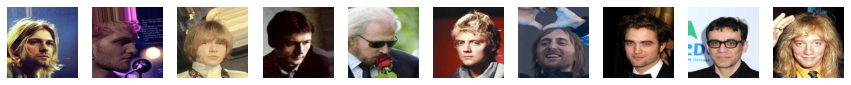

In [259]:
# become more female, male gender but female expression
display(sampled.sort_values('delta').head(30).index.values)

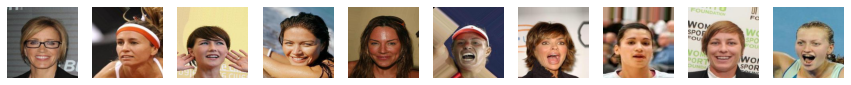

In [241]:
# become more male, female gender but male expression
display(sampled.sort_values('delta').tail(10).index.values)

In [242]:
sampled

,gender,male_gender_prob,female_gender_prob,male_expr_pred_prob,female_expr_pred_prob,delta
129507.jpg,0,0.002603,0.997397,0.685747,0.314253,0.683144
032535.jpg,1,0.824646,0.175354,0.651932,0.348068,-0.172713
052429.jpg,1,0.990409,0.009591,0.851239,0.148761,-0.139170
014262.jpg,0,0.009436,0.990564,0.617099,0.382901,0.607663
110277.jpg,1,0.929627,0.070373,0.719216,0.280784,-0.210411
...,...,...,...,...,...,...
109035.jpg,1,0.976254,0.023746,0.953077,0.046923,-0.023177
062822.jpg,0,0.022762,0.977238,0.144700,0.855300,0.121938
070510.jpg,1,0.991748,0.008252,0.748423,0.251577,-0.243325
012449.jpg,0,0.004460,0.995540,0.213793,0.786207,0.209333


In [246]:
all_sampled = df.loc[sampled.index.values]

In [247]:
all_sampled['gender'] = sampled['gender']
all_sampled['male_gender_prob'] = sampled['male_gender_prob']
all_sampled['female_gender_prob'] = sampled['female_gender_prob']
all_sampled['male_expr_pred_prob'] = sampled['male_expr_pred_prob']
all_sampled['female_expr_pred_prob'] = sampled['female_expr_pred_prob']

In [251]:
all_sampled.columns

Index(['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes',
       'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair',
       'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin',
       'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones',
       'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
       'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair',
       'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
       'Wearing_Necklace', 'Wearing_Necktie', 'Young', 'gender',
       'male_gender_prob', 'female_gender_prob', 'male_expr_pred_prob',
       'female_expr_pred_prob'],
      dtype='object')

In [250]:
all_sampled.corr()

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,gender,male_gender_prob,female_gender_prob,male_expr_pred_prob,female_expr_pred_prob
5_o_Clock_Shadow,1.000000,-0.168962,-0.029271,0.147374,-0.009840,-0.099714,-0.037630,0.127336,0.102619,-0.134215,...,0.028568,-0.324430,-0.108180,0.115295,0.022889,0.394633,0.406295,-0.406295,0.315492,-0.315492
Arched_Eyebrows,-0.168962,1.000000,0.246374,-0.105471,-0.074098,-0.007716,0.261600,-0.091575,-0.001480,0.146957,...,-0.098365,0.478823,0.244238,-0.123798,0.144578,-0.439882,-0.435301,0.435301,-0.311167,0.311167
Attractive,-0.029271,0.246374,1.000000,-0.171118,-0.147330,0.054788,0.038209,-0.278627,0.011625,0.147169,...,-0.130430,0.457442,0.050118,-0.149229,0.390226,-0.388921,-0.381659,0.381659,-0.333247,0.333247
Bags_Under_Eyes,0.147374,-0.105471,-0.171118,1.000000,0.113172,-0.043442,-0.000939,0.362835,0.012448,-0.100640,...,-0.028034,-0.260009,-0.053619,0.183032,-0.230253,0.271376,0.278363,-0.278363,0.262460,-0.262460
Bald,-0.009840,-0.074098,-0.147330,0.113172,1.000000,-0.066795,-0.006272,0.184274,-0.088927,-0.063117,...,-0.038648,-0.135600,-0.051775,0.166126,-0.185945,0.164188,0.167954,-0.167954,0.121789,-0.121789
Bangs,-0.099714,-0.007716,0.054788,-0.043442,-0.066795,1.000000,0.058051,-0.082885,-0.016791,0.091677,...,-0.086127,0.171660,0.132591,-0.099593,0.035910,-0.171895,-0.176934,0.176934,-0.184689,0.184689
Big_Lips,-0.037630,0.261600,0.038209,-0.000939,-0.006272,0.058051,1.000000,0.072913,0.055083,0.031406,...,0.012150,0.214190,0.137884,-0.062310,0.142722,-0.182127,-0.186195,0.186195,-0.185004,0.185004
Big_Nose,0.127336,-0.091575,-0.278627,0.362835,0.184274,-0.082885,0.072913,1.000000,0.084723,-0.139361,...,0.057634,-0.314878,-0.042558,0.200092,-0.278763,0.374166,0.379921,-0.379921,0.327095,-0.327095
Black_Hair,0.102619,-0.001480,0.011625,0.012448,-0.088927,-0.016791,0.055083,0.084723,1.000000,-0.216764,...,-0.098673,-0.064632,-0.043960,0.059542,0.114209,0.122125,0.118682,-0.118682,0.107771,-0.107771
Blond_Hair,-0.134215,0.146957,0.147169,-0.100640,-0.063117,0.091677,0.031406,-0.139361,-0.216764,1.000000,...,-0.090488,0.287588,0.144633,-0.113979,0.065122,-0.309773,-0.311008,0.311008,-0.302086,0.302086


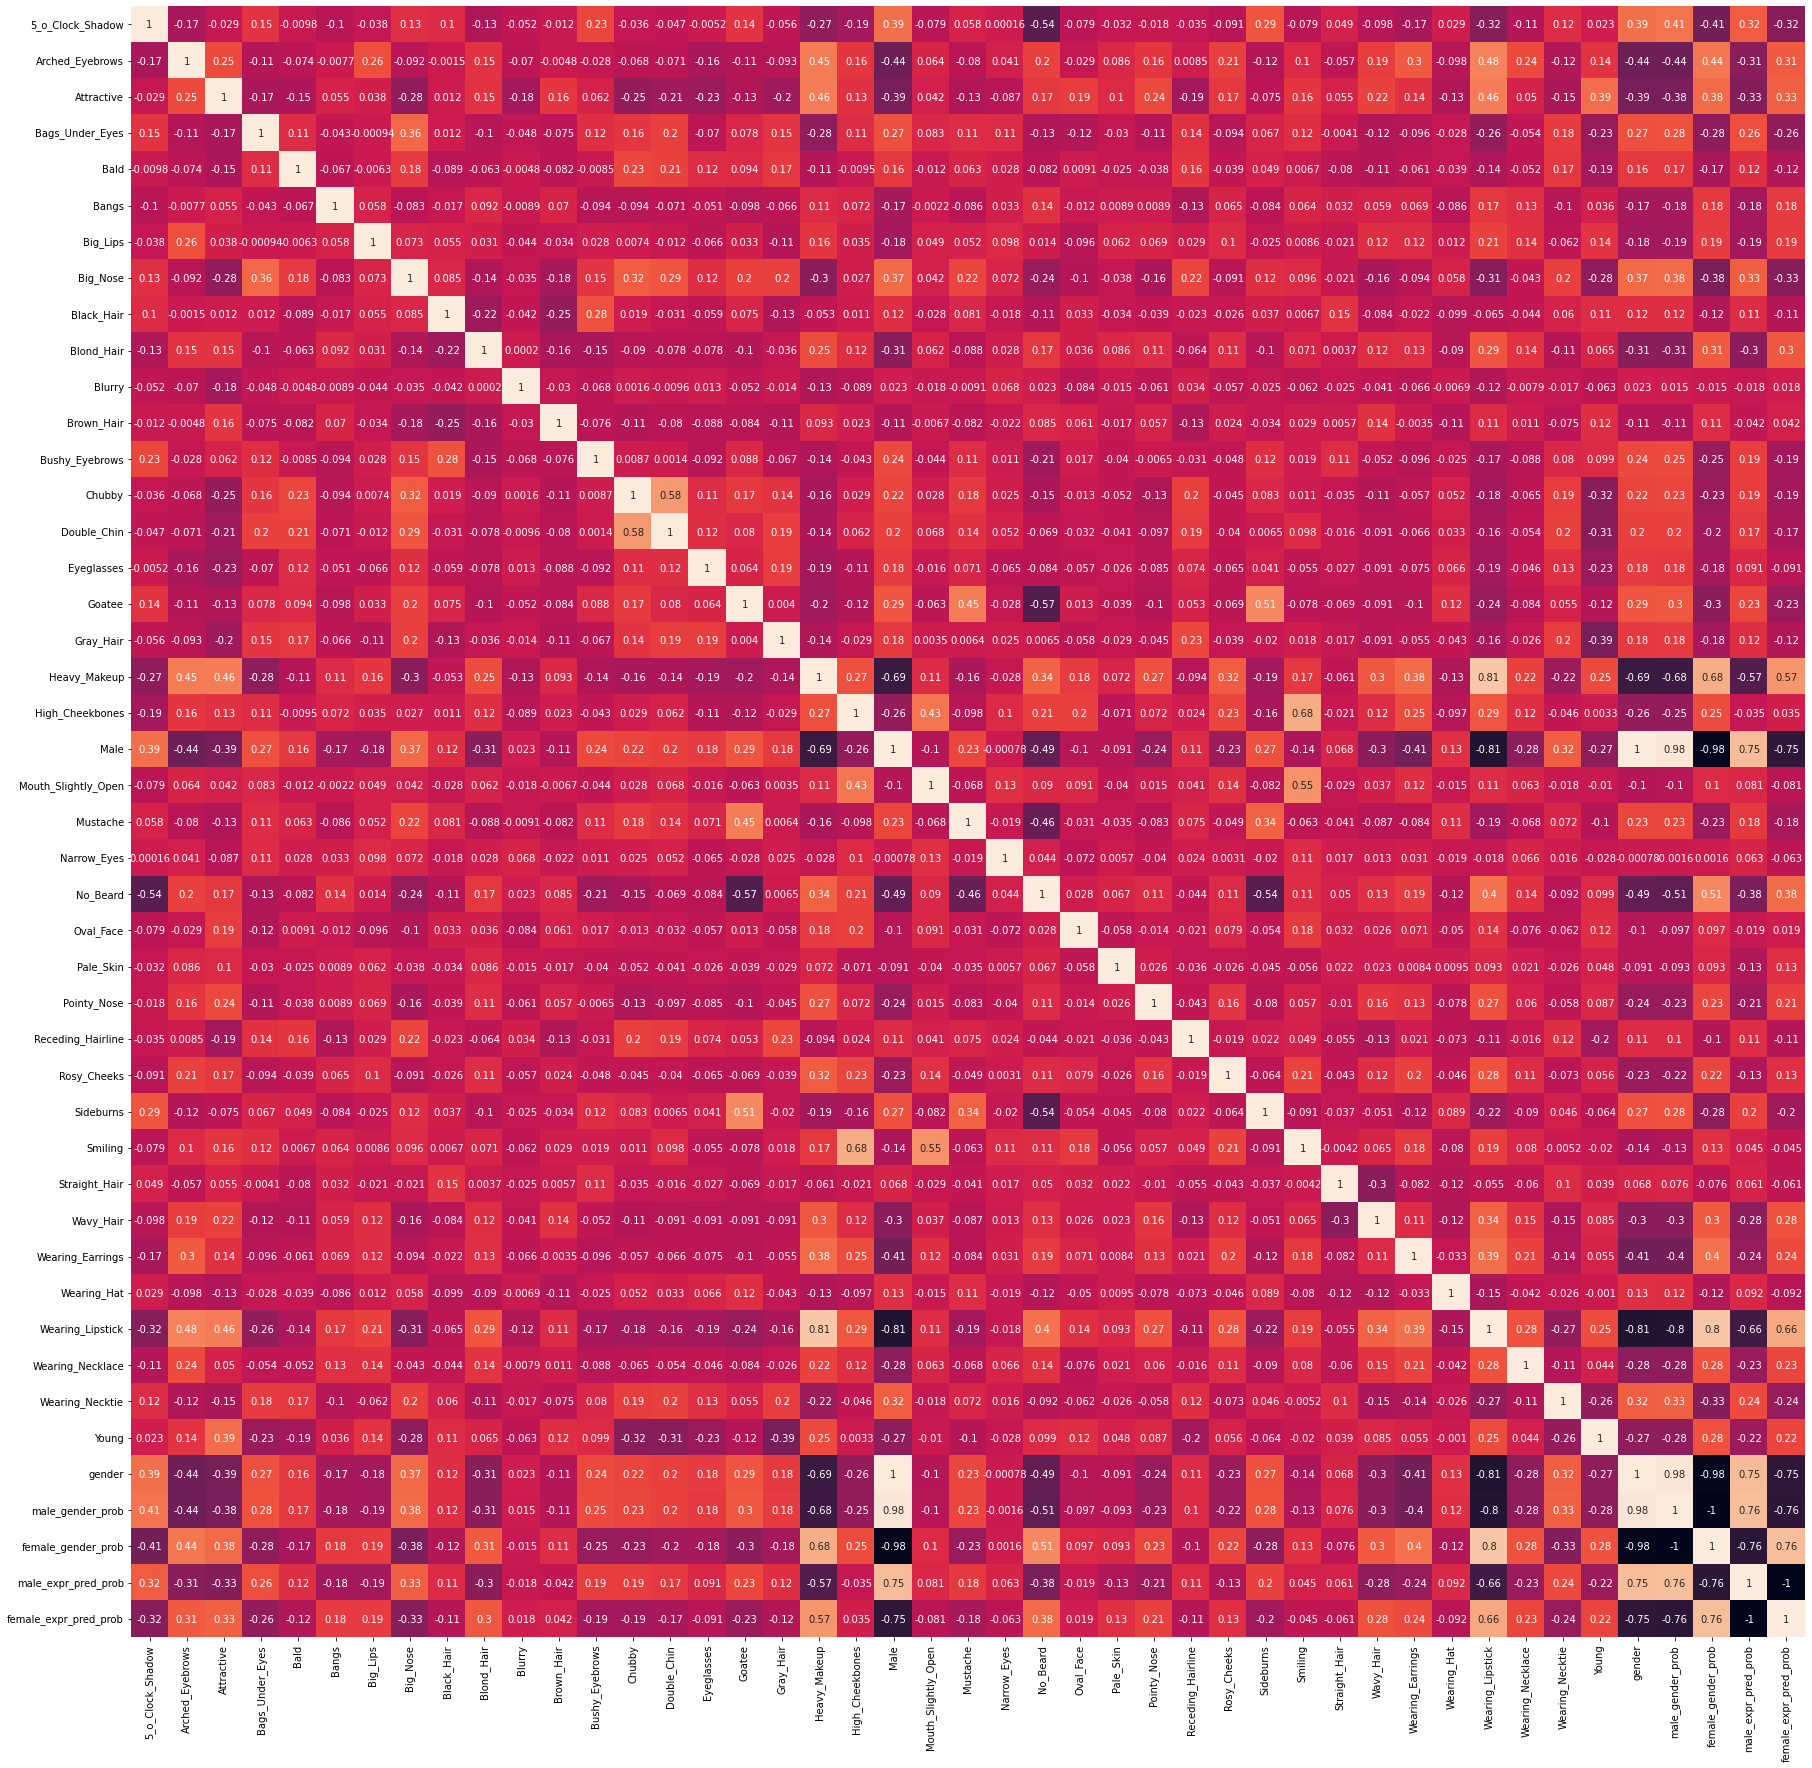

In [256]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(30,30))
sns.heatmap(all_sampled.corr(), annot=True, cbar=False)
plt.show()